# Including

In [1]:
# executeme
using NBInclude
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Model Parameters

<font size="5">
    $\alpha=\frac{p}{q}=\frac{p}{N_y}, N_\phi=\frac{N_xN_y}{q}=N_x \text{(The number of single particle degeneracy)}$
</font>

In [2]:
Nx=8; Ny=10; N=Nx*Ny
p=1; q=Ny
cut_off=Nx
PN=[0,1,2,3]
U=2;

# Sub Space Kinetic Term

In [3]:
# executeme
sp_basis = NLevelBasis(N)
periodicity = 0 #periodic (select 1 for hard-wall conditions)
sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity);

In [4]:
# executeme
H1 = get_sp_op(sp_basis, N, sp_matrix);

In [5]:
# executeme
using LinearAlgebra
eigenenergies(dense(H1)) == eigvals(sp_matrix) #true
eigvals(sp_matrix);

In [6]:
# executeme
sub_states = get_sub_states(H1, cut_off);

In [7]:
# executeme
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [8]:
# executeme
H1_sub = get_subspace_op(H1, P, Pt);

In [9]:
# executeme
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Sub Space Hubbard Interaction Term

In [10]:
# executeme
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [11]:
# executeme
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);

In [12]:
# executeme
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [13]:
# executeme
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
H_Int = Hubbard_Interaction(P, Pt, basis_cut_mb, cut_off, U);

# Total Hamiltonian with Impurity Potential

In [16]:
# executeme

H_Kin = SparseOperator(basis_cut_mb)
H_Kin.data = H1_MB.data

num_mb_list_op = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

function get_total_H(V_1, V_2, imp_site_1, imp_site_2, num_mb_list_op, H_Kin, H_Int)
    
    V_imp_1 = V_1 * num_mb_list_op[imp_site_1]
    V_imp_2 = V_2 * num_mb_list_op[imp_site_2]
    H = H_Kin + H_Int + V_imp_1 + V_imp_2
    
    return H
end

get_total_H (generic function with 2 methods)

In [17]:
imp_site_1 = 44
imp_site_2 = 30
V_1 = 4 # Impurity potential strength
V_2 = 0

In [ ]:
# executeme
H = get_total_H(V_1, V_2, imp_site_1, imp_site_2, num_mb_list_op, H_Kin, H_Int);

<font size="4">
    \begin{align*}
    &\text{Filling fraction: \quad} \nu=\frac{N}{N_{\Phi}} = \frac{3}{8}, \quad \text{Laughlin fraction: } \frac{N}{N_{\Phi}}=\frac{3}{6}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles. One of them is pinned.}
    \end{align*}
</font>

# Exact Diagonalization

In [18]:
# executeme
using DataFrames

E, UU = eigenstates(dense((H+H')/2))

function get_energies(pn, E, UU, basis)
    
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), UU[i])) 
        PN_Energies[i,2] = E[i] 
    end
    
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [19]:
PN

4-element Vector{Int64}:
 0
 1
 2
 3

In [45]:
pn = 3

3

In [20]:
# executeme
df = get_energies(pn, E, UU, basis_cut_mb)
filtered_energies = Matrix(df)[:,2];

In [21]:
# Onur hocanın makalesinde ki FIG1 çıktısı

# using Plots
# using LaTeXStrings
# Plots.plot(1:35, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)
# #ylims!((-7.20544,-7.20536))

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [22]:
# executeme
function restricted_hubbard_states(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states]
end

restricted_hubbard_states (generic function with 1 method)

In [23]:
# executeme
r_hubbard_states = restricted_hubbard_states(UU);

# Density Profile

In [24]:
# executeme
num_mb_storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N)
num_mb_matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb))
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            num_mb_matrix[i,j] = num_mb_list_op[m].data[i,j]
        end
    end
    num_mb_storage[:,:,m] = num_mb_matrix
end

<font size="5">
$<\psi_j|n_i|\psi_j>$
</font>

In [25]:
# executeme
BL = BR = basis_cut_mb
function get_density_profile(num_mb_storage, r_hubbard_states, index_eig_states)
    expect_list = []
    for i in 1:N
        T = num_mb_storage[:,:,i]
        Op = Operator(BL,BR,T)   
        push!(expect_list, expect(Op, r_hubbard_states[index_eig_states]))
    end
    return real(expect_list)
end

get_density_profile (generic function with 1 method)

<font size="4">
    \begin{align*}
    &\text{The number of ground manifold degeneracy (} \mathscr{D} \text{)} = \frac{(N_d+N-1)!}{N_d!(N-1)!}\frac{N_\phi-N_d}{N} \\
    &\text{The number of delocalised quasihole:}N_d
    \end{align*}
<end font>

In [29]:
N_d = 1
D = (factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * ((Nx - N_d) / pn)

7

In [30]:
# executeme
Degeneracy = Int(D) # Sub space ground state degeneracy
avg_density = zeros((Nx,Ny)) 
for index_eig_states in 1:Degeneracy
    global avg_density += reshape(get_density_profile(num_mb_storage, r_hubbard_states, index_eig_states), Nx, Ny)
end    
avg_density = avg_density / Degeneracy;

# Interpolation

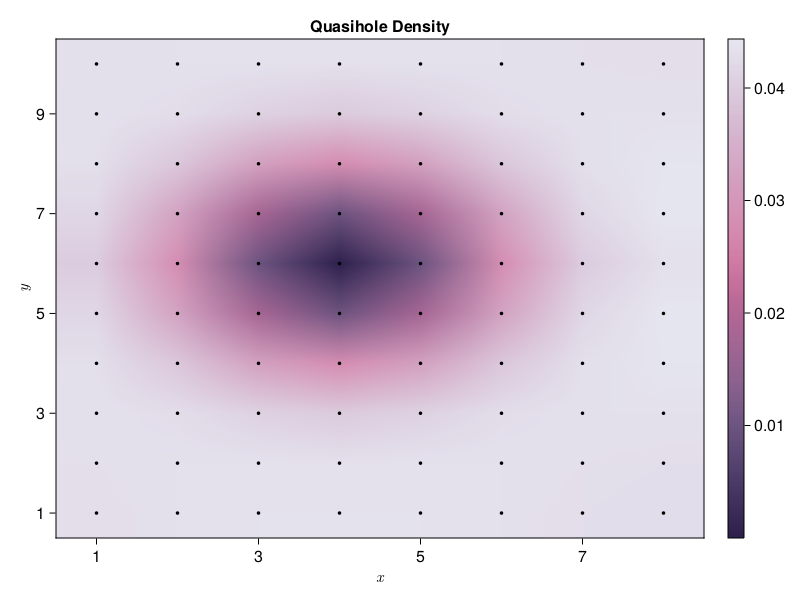

In [47]:
using CairoMakie

fig = Figure()
ax = Axis(fig[1,1], title="Quasihole Density", xlabel=L"$x$", ylabel=L"$y$")
ax.xticks = 1:2:Nx
ax.yticks = 1:2:Ny

hm = CairoMakie.heatmap!(avg_density, colormap=:acton, interpolate=true, aspect_ratio=:equal)
Colorbar(fig[1, 2], hm)

x_coordinates = square_lattice(Nx,Ny)[2][:,1] .+ 1
y_coordinates = square_lattice(Nx,Ny)[2][:,2] .+ 1
CairoMakie.scatter!(x_coordinates, y_coordinates, color=:black, markersize=5)

fig

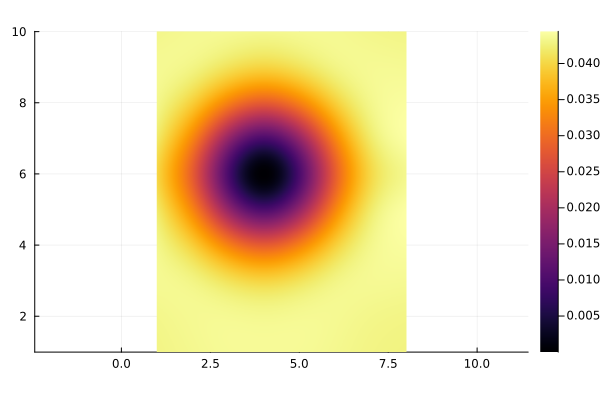

In [52]:
# executeme

using Plots
using Interpolations

function Interp2D(data, factor)
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)
    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)
    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end
    return finery, finerx, data_interp
end

data = avg_density|>transpose
factor = 50

Plots.heatmap(Interp2D(data, factor), aspect_ratio=:equal)

# Torus Distance and Equivalent (Periodic) Sites

In [79]:
@nbinclude("Torus_Distance.ipynb");

In [82]:
coordinates, lattice = get_square_lattice(Nx, Ny)
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(coordinates)
ref_coordinates = coordinates
ref_site = 36 # Site Pinned (Site 44 = Site 36)
radius_list = get_radii(ref_coordinates, ref_site);

In [83]:
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny);

# Density Plot and $Q_{\rho}$ Calculation

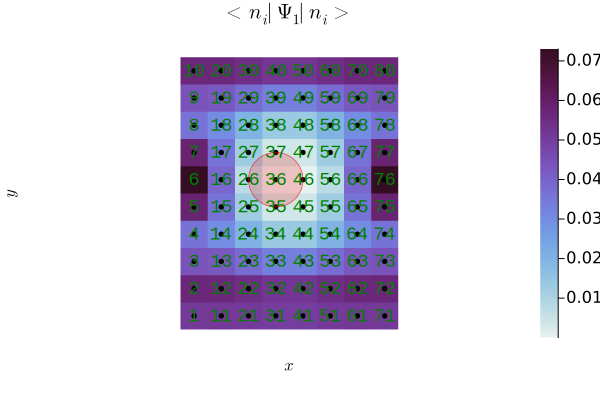

In [84]:
using Plots
using LaTeXStrings

# Density Plot
index_eig_states = 1
Plots.heatmap(reshape(get_density_profile(num_mb_storage, r_hubbard_states, index_eig_states), Nx, Ny)|>transpose, colormap=:dense)

# koordinatları 0 yerine 1'den başlatırsak heatmap ile uyumlu olur (.+1 operasyonu)
x_coordinates = coordinates[:,1] .+1
y_coordinates = coordinates[:,2] .+1
Plots.scatter!(x_coordinates, y_coordinates, label=false, aspect_ratio=1, showaxis = false, grid=false, markersize=3, c=:black, title=L"$<n_i|\Psi_1|n_i>$", xlabel=L"$x$",ylabel=L"$y$")

# Site Index
for i in 1:N
    p = annotate!(x_coordinates[i],y_coordinates[i], text("$i", :Courier, 10,:green))
end

# Circle
function circle_shape(h,k,r)
    beta = reverse(LinRange(0, 2*pi, 500))
    h .+ r*sin.(beta), k .+ r*cos.(beta)
end

# Bu örnekte imp_site=44 aslında 36.site'dır. Çünkü burada density en düşüktür!
center_x = x_coordinates[36]; center_y = y_coordinates[36]; radius = 1
Plots.plot!(circle_shape(center_x,center_y,radius), seriestype=[:shape], lw=0.5, c=:red, linecolor= :red, legend=false, fillalpha=0.2)

p

In [85]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = coordinates # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

<font size="4">
\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\
&\text{Isotropic (uniform) reference particle density:}<n_i>_{V=0} \\
&<n_i>_{V=0} \approx \frac{N}{(N_\phi-1)N_y} = \frac{3}{70} \\
&Q=\frac{N}{N_\phi-1}=\frac{3}{7}
\end{align*}
</font>

In [39]:
function get_depletion_profile(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((3/70 .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile (generic function with 1 method)

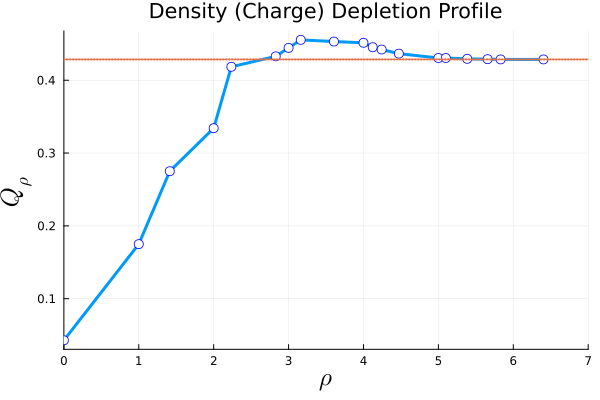

In [40]:
depletion_prof = get_depletion_profile(radius_list, avg_density)
Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))
Q = 3/7
g(x)=Q; x=0
Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))